## Appendix B. Robustness Test

Due to the size of the database (**1.3M** python questions), sampling is done. 
However, due to the random nature of sampling, robustness of the sampling must be checked. In particular, the features and their weights were tested as to whether the results are similar for the different trials. This was done for 20 trials. Two validations are performed.
1. Standard deviation of top features. The weight of the top features are compared across different sampled corpus.
2. Jaccard similarity, $\frac{A\cap B}{A\cup B}$. Using this, the total feature weights of each sampled corpus were compared with each other.

In [1]:
import sqlite3
conn = sqlite3.connect('/mnt/processed/private/msds2020/lt13/database/stackoverflow.db')

### Appendix B.1. Random sampling

SQL queries are not optimized for random sampling. As such, the sampling was done by randomly choosing indices (corresponding to the row identifier `Id`). To avoid long loops, the posts were sampled by thousands of the index (e.g. if the randomly chosen index is 231, rows with `Id` from 231000 to 231999 will be chosen. Note, however, that this does not imply 1000 consecutive posts will be chosen per iteration since the posts retain their unique ID even after filtering. In fact, only about tens of consecutive posts were sampled each iteration which is a tradeoff between speed and the bias of consecutive posts.

The titles were vectorized using TF-IDF to account for the common terms in asking a question, e.g. "how". English stopwords were filtered along with the words "using" and "use". Moreover, the word "python" was also filtered since the posts were already filtered according to python and so, will only cause unwanted differences to the titles containing the word and those that do not. A word must also at least consist of two word characters and occurs in 0.1% of the corpus. Lastly, the vectors were binarized such that multiple occurrence of a word in the same title does not imply multiple importance of the word.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from sklearn.decomposition import TruncatedSVD
import pickle
stop_words = stopwords.words('english') + ['python', 'using', 'use']


def generate_samples(N, conn):
    """Sample 10000 rows from the database, vectorize the titles, reduce the
    dimensions using truncatedSVD and store in a pickle file a dictionary 
    containing the following information:
        bow : vectorized titles
        feats : feature names corresponding to the columns of bow
        posts : the sampled rows
        trunc_elbow : tuple containing the number of PCs retained and the 
            truncated design matrix using the elbow method
        trunc_0.8 : tuple containing the number of PCs retained and the 
            truncated design matrix using the 80% variance explained method
    """
    cur = conn.cursor()
    cur.execute("""SELECT MAX(Id) FROM PostsQuestions
            WHERE Id LIKE '________'""")

    max_id = int(cur.fetchall()[0][0])
    for trial_no in range(N):
        print(trial_no)
        idxs = list(range(max_id//1000))
        posts = []
        while len(posts) < 1e4:
            idx = random.choice(idxs)
            cur.execute(f"""SELECT DISTINCT * FROM PostsQuestions 
                        WHERE tags LIKE "%python%"
                        AND AcceptedAnswerId IS NOT NULL
                        AND Id BETWEEN {idx*1000} AND {idx*1000+999}
                        AND Id LIKE '{idx}___'""")
            posts.extend(cur.fetchall())
            idxs.remove(idx)

        tags = list(zip(*posts))
        ids, titles = tags[0], tags[11]

        tfidf_vectorizer = TfidfVectorizer(token_pattern='\w{2,}',
                                           stop_words=stop_words,
                                           min_df=0.001,
                                           binary=True)
        bow = tfidf_vectorizer.fit_transform(titles)

        V = np.cov(bow.toarray(), rowvar=False)

        lambdas, w = np.linalg.eig(V)
        indices = np.argsort(lambdas)[::-1]
        lambdas = lambdas[indices]
        w = w[:, indices]
        var_explained = lambdas / lambdas.sum()
        for m in range(len(var_explained)):
            if var_explained[m] < 0.1*var_explained[0]:
                break
        m += 1
        cum_var_explained = var_explained.cumsum()

        n_PC = np.searchsorted(cum_var_explained, 0.8)

        X = TruncatedSVD(n_components=n_PC).fit_transform(bow)
        X_m = TruncatedSVD(n_components=m).fit_transform(bow)

        feats = tfidf_vectorizer.get_feature_names()

        files_ = {'bow': bow, 'feats': feats, 'posts': posts,
                  'trunc_elbow': (m, X_m), 'trunc_0.8': (n_PC, X)}
        pickle.dump(files_, open(
            f'/mnt/processed/private/msds2020/lt13/pickle/robustness_trials/T{trial_no}', 'wb'))


generate_samples(N=20, conn=conn)

### Appendix B.2. Top features robustness

One way to check robustness across different samples is by comparing the weights of the top features for each of the sampled corpus. But first, the top 10 features must first be identified.

In [6]:
T = []
for t in range(20):
    T.append(pickle.load(open(f'/mnt/processed/private/msds2020/lt13/pickle/robustness_trials/T{t}', 'rb')))
wgts_base = []
feats_base = []
for t in T:
    wgts_base.extend(list(t['bow'].toarray().sum(axis=0)))
    feats_base.extend(t['feats'])
    
top_idx = np.argsort(np.array(wgts_base))[::-1]
top_fts = list(zip(np.array(feats_base)[top_idx], np.array(wgts_base)[top_idx]))
top_fts = list(dict(top_fts).keys())[:10]
print(top_fts)

['list', 'django', 'file', 'error', 'function', 'string', 'pandas', 'get', 'data', 'values']


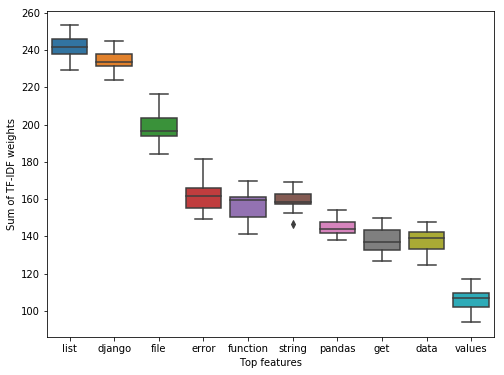

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))
df_feat = pd.DataFrame()
for i in top_fts:
    fts_wgt = []
    for t in T:
        try:
            fts_idx = t['feats'].index(i)
            fts_wgt.append(t['bow'].toarray()[:,fts_idx].sum())
        except:
            fts_wgt.append(0)
    df_feat[i] = fts_wgt

sns.boxplot(data=df_feat, ax=ax)
ax.set_ylabel("Sum of TF-IDF weights")
ax.set_xlabel("Top features");

Looking at the weights, the values are consistent for the top 10 features. Using StandardScaler to check how many standard deviations the minimum and the maximum are:

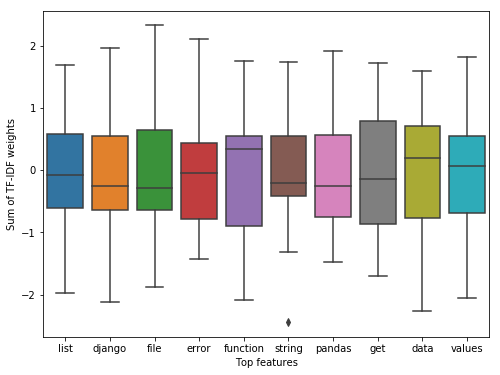

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_feat = pd.DataFrame(scaler.fit_transform(df_feat), columns=df_feat.columns)
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df_feat, ax=ax)
ax.set_ylabel("Sum of TF-IDF weights")
ax.set_xlabel("Top features");

From which we see the features are within 2 standard deviations.

### Appendix B.3. Jaccard index for robustness

Another method to check for robustness is to compute the pairwise Jaccard index of the different samples.

In [17]:
def jaccard(A, B, feats):
    """Calculate the Jaccard index of two sampled corpus.
    
    Parameters
    ----------
    A, B : dict
        dictionary with features as keys and weights as values
    feats : list of str
        list of the feature names
    """
    jacc_i = 0
    for i in feats:
        if A[i] > 0:
            jacc_i += np.min([A[i], B.get(i, 0)]) / np.max([A[i], B.get(i, 0)])
        else:
            print(i)
    jacc_i /= len(feats)
    return jacc_i

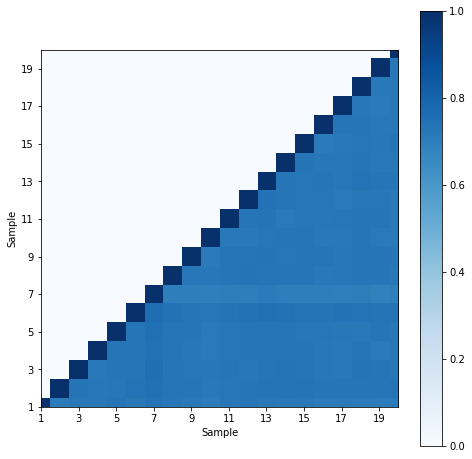

In [21]:
jac_sim = np.zeros((20, 20))
for i in range(20):
    data_0 = pickle.load(open(
        f'/mnt/processed/private/msds2020/lt13/pickle/robustness_trials/T{i}', 'rb'))

    bow0 = data_0['bow']
    wgt_0 = bow0.sum(axis=0)
    feats_0 = data_0['feats']
    A = dict(zip(feats_0, np.array(wgt_0).reshape(wgt_0.shape[1])))
    for n in range(i, 20):
        data_n = pickle.load(open(
            f'/mnt/processed/private/msds2020/lt13/pickle/robustness_trials/T{n}', 'rb'))

        bown = data_n['bow']
        wgt_n = bown.sum(axis=0)
        feats_n = data_n['feats']
        B = dict(zip(feats_n, np.array(wgt_n).reshape(wgt_n.shape[1])))

        jac_sim[i, n] = jaccard(A, B, feats_0)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(jac_sim, cmap='Blues')
ax.set_xlabel("Sample")
ax.set_ylabel("Sample")
ax.set_xticks([i for i in range(0, 21, 2)])
ax.set_yticks([i for i in range(0, 21, 2)])
ax.set_xlim(0, 19)
ax.set_ylim(0, 19)
ax.set_xticklabels([i+1 for i in range(0, 20, 2)])
ax.set_yticklabels([i+1 for i in range(0, 20, 2)])
plt.colorbar(im, ax=ax)
# fig.savefig('robustness.png', dpi=300)

From which we see pairwise Jaccard index of at least 70%